# Linear regression in ajax

In [7]:
try:
  import optax
except:
  %pip install -qq optax
  import optax
try:
    from ajax import ADVI
except:
   %pip install -qq git+https://github.com/patel-zeel/ajax.git
   from ajax import ADVI

try:
  import tensorflow_probability.substrates.jax as tfp
except:
  %pip install -qq tensorflow_probability.substrates.jax
  import tensorflow_probability.substrates.jax as tfp

try:
  import jax.numpy as jnp
except:
  %pip install -qq jax
  import jax.numpy as jnp

try:
    import seaborn as sns
except:
    %pip install -qq seaborn 
    import seaborn as sns
from ajax.utils import train
import jax
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from functools import partial
tfd = tfp.distributions
tfb = tfp.bijectors
import seaborn as sns

In [8]:
url =  "https://raw.githubusercontent.com/AnandShegde/pml_baselines/main/data/linear_regression/linear_regression"
data = pd.read_pickle(url)
data

{'data': {'x': array([[ 1.7598495 ],
         [-0.23643708],
         [ 3.1509051 ],
         [-0.79705334],
         [-2.500547  ],
         [ 1.6101036 ],
         [ 0.14806175],
         [ 0.05331182],
         [ 2.6665907 ],
         [-0.14456654]], dtype=float32),
  'y': array([[ 9.011515 ],
         [ 5.4843464],
         [ 9.670069 ],
         [ 1.1274505],
         [-1.283633 ],
         [ 7.062801 ],
         [ 3.6567392],
         [ 2.2533112],
         [10.321623 ],
         [ 2.2750926]], dtype=float32)},
 'noise_variance': 1,
 'prior': {'mean': array([14. ,  7.3], dtype=float32),
  'var': array([[10.,  0.],
         [ 0., 10.]], dtype=float32),
  'alpha': 1,
  'beta': 1}}

In [9]:
X = data['data']['x']
Y = jnp.array(data['data']['y']).reshape((-1))

def identity_trans(x):
    return jnp.append(jnp.ones((m,1)),x,axis=1)

m = X.shape[0]
X = identity_trans(X)
mean_prior = data['prior']['mean']
var_prior = jnp.array(data['prior']['var'])

## Defining model with ajax

In [12]:
prior = {
        "theta" : tfp.distributions.MultivariateNormalDiag(loc = mean_prior, scale_diag = jnp.diagonal(var_prior))
}

bijectors = {
    "theta" : tfb.Identity()
}

def get_log_likelihood(params, aux, data,**kwargs):
    mean = aux["X"] @ params["theta"]
    diag = jnp.ones_like(mean)
    likelihood = tfd.MultivariateNormalDiag(loc=mean, scale_diag = diag)
    return likelihood.log_prob(data).sum()

model = ADVI(prior, bijectors, get_log_likelihood, vi_type = "full_rank")

## Training the model

Text(0, 0.5, 'loss')

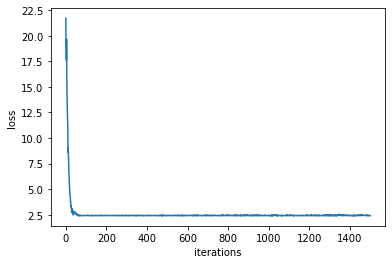

In [23]:
optimizer = optax.adam(learning_rate=0.1)
epochs = 1500
seed = jax.random.PRNGKey(10)
params = model.init(seed)

loss_fn = partial(model.loss_fn,batch = Y,  data_size = len(Y), aux = {"X":X}, n_samples = 10)
model_params = train(loss_fn, params, optimizer = optimizer, n_epochs = epochs, seed = jax.random.PRNGKey(10),return_args = ["losses"])

plt.plot(model_params["losses"])
plt.xlabel("iterations")
plt.ylabel("loss")

## Plotting results

In [19]:
url = "https://raw.githubusercontent.com/AnandShegde/pml_baselines/main/results/linear_regression/results_data/linear_regression_true_posterior"
distribution_params = pd.read_pickle(url)

mean = distribution_params["mean"]
cov = distribution_params["covariance"]

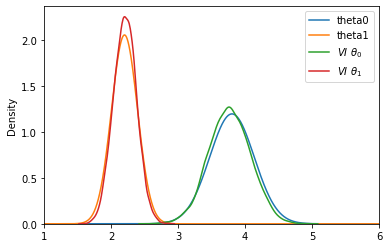

In [24]:
plt.xlim(1,6)
x = jnp.linspace(1,6,10000)

normal1 = tfd.Normal(mean[0],jnp.sqrt(cov[0,0]))
pdf1 = normal1.prob(x)
plt.plot(x,pdf1,label="theta0")
normal2 = tfd.Normal(mean[1],jnp.sqrt(cov[1,1]))
pdf2=  normal2.prob(x)
plt.plot(x,pdf2,label="theta1")

posterior = model.apply(model_params["params"])
samples = posterior.sample(seed = jax.random.PRNGKey(10),sample_shape = (10000,))
sns.kdeplot(samples["theta"][:,0],label=r"$VI\ \theta_0$")
sns.kdeplot(samples["theta"][:,1],label = r"$VI\ \theta_1$")
plt.legend()


In [25]:
with open("../results/linear_regression/results_data/linear_regression_Ajax",'wb') as f:
    pickle.dump(posterior, f,protocol = 1)